In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Normalization
import tensorflow as tf
# from google.colab.patches import cv2_imshow

In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        # ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)


    return ious_mat



def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):

    anc_boxes_all, gt_bboxes_all, gt_classes_all = anc_boxes_all.to(device), gt_bboxes_all.to(device), gt_classes_all.to(device)
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all).to(device)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]

    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # get gt classes of the +ve anchor boxes
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]


    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]


    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

# # -------------- Visualization utils ----------------
def tensorimshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def display_img(img_data, fig, axes):
    inp = img_data.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axes.imshow(inp)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)

    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category

        name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
        idx2name = {v:k for k, v in name2idx.items()}

        if not classes == None:
            if idx2name[classes[c].item()] == 'pad':
                continue
            ax.text(x + 5, y + 20, idx2name[classes[c].item()] , bbox=dict(facecolor='yellow', alpha=0.5))

        c += 1

    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

In [26]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        # ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)


    return ious_mat



def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):

    anc_boxes_all, gt_bboxes_all, gt_classes_all = anc_boxes_all.to(device), gt_bboxes_all.to(device), gt_classes_all.to(device)
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all).to(device)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]

    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # get gt classes of the +ve anchor boxes
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]


    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]


    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

# # -------------- Visualization utils ----------------
def tensorimshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def display_img(img_data, fig, axes):
    inp = img_data.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axes.imshow(inp)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)

    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category

        name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
        idx2name = {v:k for k, v in name2idx.items()}

        if not classes == None:
            if idx2name[classes[c].item()] == 'pad':
                continue
            ax.text(x + 5, y + 20, idx2name[classes[c].item()] , bbox=dict(facecolor='yellow', alpha=0.5))

        c += 1

    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

In [19]:
import os

#this is counts of images for each class for train data
def read_text_files(folder_path):
    # Initialize a dictionary to store value counts
    value_counts = {}

    # Iterate through each file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r") as file:
                for line in file:
                    # Extract the value from the first column (assuming space-separated)
                    value = line.split()[0]

                    # Update the value count in the dictionary
                    value_counts[value] = value_counts.get(value, 0) + 1

    return value_counts
class_names = {
         "0": "fish",
         "1": "jellyfish",
         "2": "penguins",
         "3": "sharks",
         "4": "puffins",
         "5": "stingrays",
         "6": "starfish"
}
if __name__ == "__main__":
    folder_path =  'aquarium_pretrain/train/labels/'# Replace with your actual folder path
    result = read_text_files(folder_path)

    # Print the counts
#     for value, count in result.items():
#         print(f"image '{value}' occurs {count} times.")
    # Print the counts and assign class names
    for value, count in result.items():
        class_name = class_names[value]
        print(f"image {class_name}: {value.capitalize()} - Count: {count}")

image fish: 0 - Count: 1961
image sharks: 3 - Count: 175
image penguins: 2 - Count: 330
image stingrays: 5 - Count: 78
image puffins: 4 - Count: 259
image starfish: 6 - Count: 136
image jellyfish: 1 - Count: 385


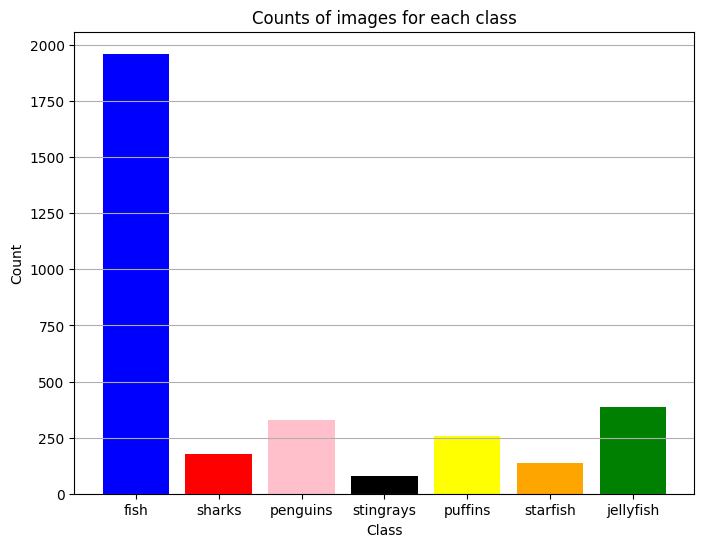

In [20]:
import matplotlib.pyplot as plt

# Given class names and their corresponding counts
class_names = ["fish", "sharks", "penguins", "stingrays", "puffins", "starfish", "jellyfish"]
class_counts = [1961, 175, 330, 78, 259, 136, 385]

selected_counts = [class_counts[class_names.index(cls)] for cls in class_names]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, selected_counts, color=["blue", "red","pink", "black", "yellow", "orange","green"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Counts of objects for each class")
plt.grid(axis="y")

# Show the plot
plt.show()


In [21]:
class_names = {
         "0": "fish",
         "1": "jellyfish",
         "2": "penguins",
         "3": "sharks",
         "4": "puffins",
         "5": "stingrays",
         "6": "starfish"
}
if __name__ == "__main__":
    folder_path =  'aquarium_pretrain/test/labels'# Replace with your actual folder path
    result1 = read_text_files(folder_path)


    for value, count in result1.items():
        class_name = class_names[value]
        print(f"image {class_name}: {value.capitalize()} - Count: {count}")

image sharks: 3 - Count: 35
image penguins: 2 - Count: 82
image fish: 0 - Count: 249
image stingrays: 5 - Count: 11
image puffins: 4 - Count: 38
image jellyfish: 1 - Count: 154
image starfish: 6 - Count: 15


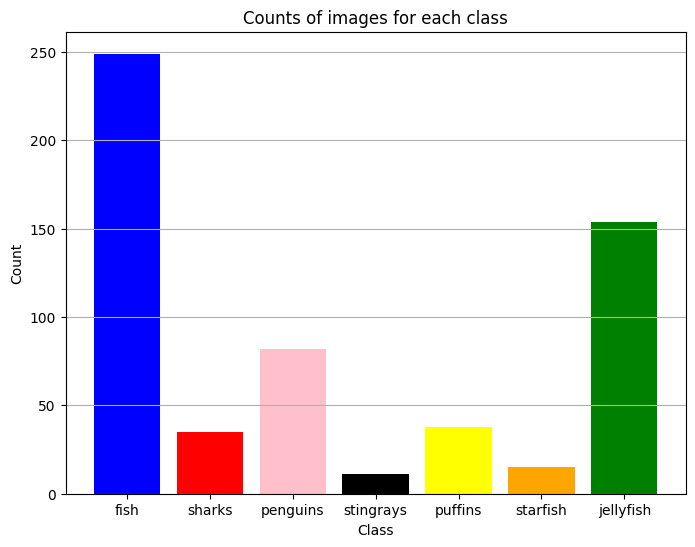

In [22]:
class_names = ["fish", "sharks", "penguins", "stingrays", "puffins", "starfish", "jellyfish"]
class_counts = [249, 35, 82, 11, 38, 15, 154]

selected_counts = [class_counts[class_names.index(cls)] for cls in class_names]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, selected_counts, color=["blue", "red","pink", "black", "yellow", "orange","green"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Counts of images for each class")
plt.grid(axis="y")

# Show the plot
plt.show()

In [23]:
#this is visualize valid images for each class
class_names = {
         "0": "fish",
         "1": "jellyfish",
         "2": "penguins",
         "3": "sharks",
         "4": "puffins",
         "5": "stingrays",
         "6": "starfish"
}
if __name__ == "__main__":
    folder_path =  'aquarium_pretrain/valid/labels'# Replace with your actual folder path
    result1 = read_text_files(folder_path)


    for value, count in result1.items():
        class_name = class_names[value]
        print(f"image {class_name}: {value.capitalize()} - Count: {count}")

image fish: 0 - Count: 459
image sharks: 3 - Count: 74
image penguins: 2 - Count: 104
image stingrays: 5 - Count: 27
image puffins: 4 - Count: 57
image starfish: 6 - Count: 33
image jellyfish: 1 - Count: 155


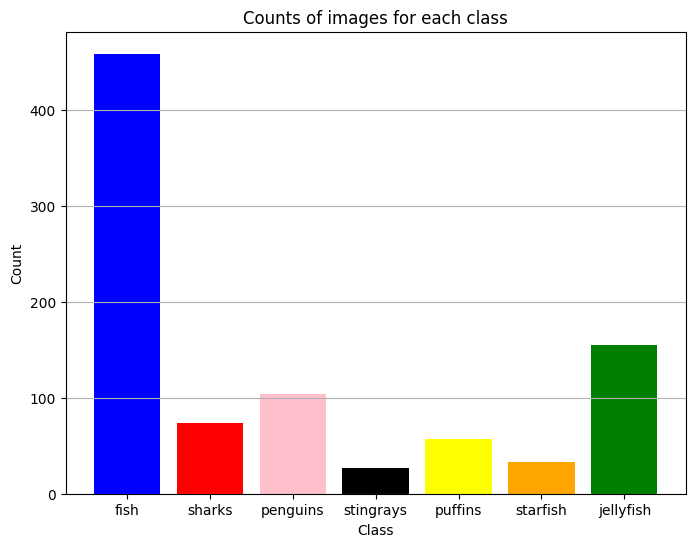

In [24]:
class_names = ["fish", "sharks", "penguins", "stingrays", "puffins", "starfish", "jellyfish"]
class_counts = [459, 74, 104, 27, 57, 33, 155]

selected_counts = [class_counts[class_names.index(cls)] for cls in class_names]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, selected_counts, color=["blue", "red","pink", "black", "yellow", "orange","green"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Counts of images for each class")
plt.grid(axis="y")

# Show the plot
plt.show()

In [65]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim


def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1)

def gen_anc_centers(out_size):
    out_h, out_w = out_size

    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5

    return anc_pts_x, anc_pts_y

def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']

    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes

    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor

    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)

    return proj_bboxes

def generate_proposals(anchors, offsets):

    # change format of the anchor boxes from 'xyxy' to 'cxcywh'
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    # apply offsets to anchors to create proposals
    proposals_ = torch.zeros_like(anchors)
    proposals_[:,0] = anchors[:,0] + offsets[:,0]*anchors[:,2]
    proposals_[:,1] = anchors[:,1] + offsets[:,1]*anchors[:,3]
    proposals_[:,2] = anchors[:,2] * torch.exp(offsets[:,2])
    proposals_[:,3] = anchors[:,3] * torch.exp(offsets[:,3])

    # change format of proposals back from 'cxcywh' to 'xyxy'
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals

def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]

    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale

                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size)

    return anc_base

def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):

    # flatten anchor boxes
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
    # get total anchor boxes for a single image
    tot_anc_boxes = anc_boxes_flat.size(dim=1)

    # create a placeholder to compute IoUs amongst the boxes
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1)))

    # compute IoU of the anc boxes with the gt boxes for all the images
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        # ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)


    return ious_mat



def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):

    anc_boxes_all, gt_bboxes_all, gt_classes_all = anc_boxes_all, gt_bboxes_all gt_classes_all
    # get the size and shape parameters
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    N = gt_bboxes_all.shape[1] # max number of groundtruth bboxes in a batch

    # get total number of anchor boxes in a single image
    tot_anc_boxes = A * w_amap * h_amap

    # get the iou matrix which contains iou of every anchor box
    # against all the groundtruth bboxes in an image
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)

    # for every groundtruth bbox in an image, find the iou
    # with the anchor box which it overlaps the most
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)

    # get positive anchor boxes

    # condition 1: the anchor box with the max iou for every gt bbox
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0)
    # condition 2: anchor boxes with iou above a threshold with any of the gt bboxes
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh)

    positive_anc_ind_sep = torch.where(positive_anc_mask)[0] # get separate indices in the batch
    # combine all the batches and get the idxs of the +ve anchor boxes
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1)
    positive_anc_ind = torch.where(positive_anc_mask)[0]

    # for every anchor box, get the iou and the idx of the
    # gt bbox it overlaps with the most
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1)

    # get iou scores of the +ve anchor boxes
    GT_conf_scores = max_iou_per_anc[positive_anc_ind]

    # get gt classes of the +ve anchor boxes
    # expand gt classes to map against every anchor box
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N)
    # for every anchor box, consider only the class of the gt bbox it overlaps with the most
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)
    # combine all the batches and get the mapped classes of the +ve anchor boxes
    GT_class = GT_class.flatten(start_dim=0, end_dim=1)
    GT_class_pos = GT_class[positive_anc_ind]


    # expand all the gt bboxes to map against every anchor box
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4)
    # for every anchor box, consider only the coordinates of the gt bbox it overlaps with the most
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    # combine all the batches and get the mapped gt bbox coordinates of the +ve anchor boxes
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]


    # get coordinates of +ve anc boxes
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2) # flatten all the anchor boxes
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]

    # calculate gt offsets
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos)

    # get -ve anchors

    # condition: select the anchor boxes with max iou less than the threshold
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    # sample -ve samples to match the +ve samples
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]

    return positive_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class_pos, \
         positive_anc_coords, negative_anc_coords, positive_anc_ind_sep

# # -------------- Visualization utils ----------------
def tensorimshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def display_img(img_data, fig, axes):
    inp = img_data.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axes.imshow(inp)

    return fig, axes

def display_bbox(bboxes, fig, ax, classes=None, in_format='xyxy', color='y', line_width=3):
    if type(bboxes) == np.ndarray:
        bboxes = torch.from_numpy(bboxes)

    # convert boxes to xywh format
    bboxes = ops.box_convert(bboxes, in_fmt=in_format, out_fmt='xywh')
    c = 0
    for box in bboxes:
        x, y, w, h = box.numpy()
        # display bounding box
        rect = patches.Rectangle((x, y), w, h, linewidth=line_width, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        # display category

        name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
        idx2name = {v:k for k, v in name2idx.items()}

        if not classes == None:
            if idx2name[classes[c].item()] == 'pad':
                continue
            ax.text(x + 5, y + 20, idx2name[classes[c].item()] , bbox=dict(facecolor='yellow', alpha=0.5))

        c += 1

    return fig, ax

def display_grid(x_points, y_points, fig, ax, special_point=None):
    # plot grid
    for x in x_points:
        for y in y_points:
            ax.scatter(x, y, color="w", marker='+')

    # plot a special point we want to emphasize on the grid
    if special_point:
        x, y = special_point
        ax.scatter(x, y, color="red", marker='+')

    return fig, ax

SyntaxError: invalid syntax (261397064.py, line 124)

In [47]:
import os
import cv2
import numpy as np

def add_pepper_noise(image):
    row, col, ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    num_pepper = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords[0], coords[1], :] = 0
    return out

def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 0.05 * 255
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def adjust_colors(image, r, g, b):
    adjusted = image.copy()
    adjusted[:,:,0] = np.clip(image[:,:,0] + b, 0, 255)
    adjusted[:,:,1] = np.clip(image[:,:,1] + g, 0, 255)
    adjusted[:,:,2] = np.clip(image[:,:,2] + r, 0, 255)
    return adjusted

# Define input and output folders
input_folder = "aquarium_pretrain/train/images"
output_folder = "Untitled Folder 2"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load all images from the input folder
image_files = os.listdir(input_folder)
for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    original_image = cv2.imread(image_path)

    # Apply augmentations
    pepper_noisy_image = add_pepper_noise(original_image)
    gaussian_noisy_image = add_gaussian_noise(original_image)
    adjusted_image_rgb = adjust_colors(original_image, r=20, g=20, b=20)
    adjusted_image_rb = adjust_colors(original_image, r=20, g=0, b=20)
    # Save augmented images
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_pepper_noisy.png"), pepper_noisy_image)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_gaussian_noisy.png"), gaussian_noisy_image)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_adjusted_image_rgb.png"), adjusted_image_rgb)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_adjusted_image_rb.png"), adjusted_image_rb)

    # Save original image
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_original.png"), original_image)

print("Augmentation complete! Images saved in the output folder.")


Augmentation complete! Images saved in the output folder.


In [53]:
import os
import cv2
import numpy as np

def add_pepper_noise(image):
    row, col, ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    num_pepper = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    out[coords[0], coords[1], :] = 0
    return out

def add_gaussian_noise(image):
    row, col, ch = image.shape
    mean = 0
    sigma = 0.05 * 255
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def adjust_colors(image, r, g, b):
    adjusted = image.copy()
    adjusted[:,:,0] = np.clip(image[:,:,0] + b, 0, 255)
    adjusted[:,:,1] = np.clip(image[:,:,1] + g, 0, 255)
    adjusted[:,:,2] = np.clip(image[:,:,2] + r, 0, 255)
    return adjusted

# Define input and output folders
input_folder = "aquarium_pretrain/valid/images"
output_folder = "valid_augmented_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load all images from the input folder
image_files = os.listdir(input_folder)
for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    original_image = cv2.imread(image_path)

    # Apply augmentations
    pepper_noisy_image = add_pepper_noise(original_image)
    gaussian_noisy_image = add_gaussian_noise(original_image)
    adjusted_image_rgb = adjust_colors(original_image, r=20, g=20, b=20)
    adjusted_image_rb = adjust_colors(original_image, r=20, g=0, b=20)
    # Save augmented images
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_pepper_noisy.png"), pepper_noisy_image)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_gaussian_noisy.png"), gaussian_noisy_image)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_adjusted_image_rgb.png"), adjusted_image_rgb)
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_adjusted_image_rb.png"), adjusted_image_rb)

    # Save original image
    cv2.imwrite(os.path.join(output_folder, f"{image_file[:-4]}_original.png"), original_image)

print("Augmentation complete! Images saved in the output folder.")


Augmentation complete! Images saved in the output folder.


# duplicate txt files

In [44]:
#this is for train labels

import os

source_folder = 'aquarium_pretrain/train/labels'
target_folder = 'Untitled Folder 1'

for root, dirs, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                content = f.read()
                for i in range(num_duplicates):
    # Create a new file name (e.g., original_file_1.txt, original_file_2.txt, etc.)
                    new_file_name = f"{os.path.splitext(file)[0]}_{i + 1}.txt"
                    new_file_path = os.path.join(target_folder, new_file_name)

    # Write the content to the new file
                    with open(new_file_path, 'w') as new_file:
                        new_file.write(content)
                

In [54]:
#this is for valid labels

import os

source_folder = 'aquarium_pretrain/valid/labels'
target_folder = 'valid_augmented_labels'

for root, dirs, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                content = f.read()
                for i in range(num_duplicates):
    # Create a new file name (e.g., original_file_1.txt, original_file_2.txt, etc.)
                    new_file_name = f"{os.path.splitext(file)[0]}_{i + 1}.txt"
                    new_file_path = os.path.join(target_folder, new_file_name)

    # Write the content to the new file
                    with open(new_file_path, 'w') as new_file:
                        new_file.write(content)
                

In [101]:
import cv2
import os
import numpy as np


# Define the directory where your images are stored
image_folder = 'aquarium_pretrain/train/images'
mosaci_folder_train_images = 'mosaic_train_images'
# List all files in the directory
image_files = [file for file in os.listdir(image_folder) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# Function to create a mosaic from four images
def create_mosaic(images, mosaic_dim=(800, 800)):
    # This assumes that mosaic_dim is a tuple of (height, width)
    # and that the provided height and width are both divisible by 2
    # Resize images to fit the mosaic dimensions
    small_dim = (mosaic_dim[1] // 2, mosaic_dim[0] // 2)
    resized_images = [cv2.resize(cv2.imread(img), small_dim, interpolation=cv2.INTER_AREA) for img in images]
    
    # Combine images into a mosaic
    top_row = np.hstack((resized_images[0], resized_images[1]))
    bottom_row = np.hstack((resized_images[2], resized_images[3]))
    mosaic = np.vstack((top_row, bottom_row))
    
    return mosaic

# Process images four at a time
i = 0
while i < len(image_files):
    batch_files = image_files[i:i+4]
    
    # Make sure there are four images to process
    if len(batch_files) == 4:
        batch_paths = [os.path.join(image_folder, f) for f in batch_files]
        # Create the mosaic
        mosaic_image = create_mosaic(batch_paths)
        
        # Save or display the mosaic image
        mosaic_path = os.path.join(mosaci_folder_train_images, f'mosaic_{i // 4}.jpg')
        cv2.imwrite(mosaic_path, mosaic_image)
        # cv2.imshow('Mosaic', mosaic_image)
        # cv2.waitKey(0)  # Wait for a key press to close the image window
    
    i += 4

print('Mosaic augmentation complete.')

Mosaic augmentation complete.


# read txt and jpg files and build dataloader with collate_fn function

In [2]:
def display_img_(img_data, fig, axes):
    for i, img in enumerate(img_data):
        if type(img) == torch.Tensor:
            img = img.permute(1, 2, 0).numpy()
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            img = np.clip(img, 0, 1)

        axes[i].imshow(img)

    return fig, axes

In [64]:
import torch
import torchvision
from torchvision import ops
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from utils import *

# -------------------- Models -----------------------

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(pretrained=True)
        req_layers = list(model.children())[:8]
        self.backbone = nn.Sequential(*req_layers)
        for param in self.backbone.named_parameters():
            param[1].requires_grad = True
        
    def forward(self, img_data):
        return self.backbone(img_data)
    
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        # determine mode
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'
            
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)
        
        if mode == 'train': 
            # get conf scores 
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            # get offsets for +ve anchors
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            # generate proposals using offsets
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals
            
        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred
        
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        
        # downsampling scale factor 
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        
        # scales and ratios for anchor boxes
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        
        # IoU thresholds for +ve and -ve anchors
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        # weights for loss
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = FeatureExtractor()
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        
        # generate anchors
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
        
        # get positive and negative anchors amongst other things
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)
        
        # pass through the proposal module
        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)

            # generate anchors
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)

            # get conf scores and offsets
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4)

            # filter out proposals based on conf threshold and nms threshold for each image
            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                # filter based on confidence threshold
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                # filter based on nms threshold
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)
            
        return proposals_final, conf_scores_final, feature_map
    
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        # hidden network
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)
        
        # define classification head
        self.cls_head = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        # apply roi pooling on proposals followed by avg pooling
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)
        
        # flatten the output
        roi_out = roi_out.squeeze(-1).squeeze(-1)
        
        # pass the output through the hidden network
        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        
        # get the classification scores
        cls_scores = self.cls_head(out)
        
        if mode == 'eval':
            return cls_scores
        
        # compute cross entropy loss
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss
    
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)
        
        # get separate proposals for each sample
        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)
        
        # convert scores into probability
        cls_probs = F.softmax(cls_scores, dim=-1)
        # get classes with highest probability
        classes_all = torch.argmax(cls_probs, dim=-1)
        
        classes_final = []
        # slice classes to map to their corresponding image
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i]) # get the number of proposals for each image
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

# ------------------- Loss Utils ----------------------

def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    target_pos = torch.ones_like(conf_scores_pos)
    target_neg = torch.zeros_like(conf_scores_neg)
    
    target = torch.cat((target_pos, target_neg))
    inputs = torch.cat((conf_scores_pos, conf_scores_neg))
     
    loss = F.binary_cross_entropy_with_logits(inputs, target, reduction='sum') * 1. / batch_size
    
    return loss

def calc_bbox_reg_loss(gt_offsets, reg_offsets_pos, batch_size):
    assert gt_offsets.size() == reg_offsets_pos.size()
    loss = F.smooth_l1_loss(reg_offsets_pos, gt_offsets, reduction='sum') * 1. / batch_size
    return loss

In [4]:
# Importing the required libraries
import os
import random
import pandas as pd

import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [52]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn_utils


class CustomDataset(Dataset):
    def __init__(self,image_width , image_height, image_folder, label_folder, transform=None):
        self.image_width =image_width
        self.image_height = image_height
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_list = sorted(os.listdir(image_folder))
        self.label_list = sorted(os.listdir(label_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load labels
        label_name = os.path.join(self.label_folder, self.label_list[idx])
        with open(label_name, 'r') as f:
            lines = f.readlines()

        labels = []
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            labels.append(int(parts[0]))
            x_c = float(parts[1])
            y_c = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            x1 = (x_c - (width/2)) * self.image_width
            y1 = (y_c - (height/2)) * self.image_height
            x2 = (x_c + (width/2)) * self.image_width
            y2 = (y_c + (height/2)) *self.image_height
            bbox = list(map(float,[x1, y1, x2, y2]))
            bboxes.append(bbox)

        labels = torch.tensor(labels, dtype=torch.long)
        bboxes = torch.tensor(bboxes, dtype=torch.float)

        return image, labels, bboxes

# Custom collate function with padding



from torch.nn.utils.rnn import pad_sequence


from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels, bboxes = zip(*batch)

    # Handle empty labels or bboxes
    # Handle empty labels or bboxes
    labels = [l.clone().detach() if l.size(0) > 0 else torch.tensor([-1]) for l in labels]
    bboxes = [b.clone().detach() if b.size(0) > 0 else torch.tensor([[0, 0, 0, 0]]) for b in bboxes]


    # Pad labels and bboxes
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    bboxes_padded = pad_sequence(bboxes, batch_first=True, padding_value=0)

    # Truncate or pad the sequences to the max_length of 34
    labels_padded = torch.stack([torch.cat([l, torch.full((44 - len(l),), -1)]) if len(l) < 44 else l[:44] for l in labels_padded], dim=0)
    bboxes_padded = torch.stack([torch.cat([b, torch.full((44 - len(b), 4), 0)]) if len(b) < 44 else b[:44] for b in bboxes_padded], dim=0)

    # Stack images
    images = torch.stack(images, dim=0)

    return images ,bboxes_padded ,labels_padded






# Example usage
image_folder = 'valid_augmented_images'
label_folder = 'valid_augmented_labels'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_width =256
image_height  =256
dataset = CustomDataset(image_width,image_height,image_folder, label_folder, transform)
val_dataloader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

for img_batch, gt_bboxes_batch, gt_classes_batch in dataloader:
    img_data_all1 = img_batch
    gt_bboxes_all1 = gt_bboxes_batch
    gt_classes_all1 = gt_classes_batch
    break
    


In [22]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn_utils


class CustomDataset(Dataset):
    def __init__(self,image_width , image_height, image_folder, label_folder, transform=None):
        self.image_width =image_width
        self.image_height = image_height
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_list = sorted(os.listdir(image_folder))
        self.label_list = sorted(os.listdir(label_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_folder, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load labels
        label_name = os.path.join(self.label_folder, self.label_list[idx])
        with open(label_name, 'r') as f:
            lines = f.readlines()

        labels = []
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            labels.append(int(parts[0]))
            x_c = float(parts[1])
            y_c = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            x1 = (x_c - (width/2)) * self.image_width
            y1 = (y_c - (height/2)) * self.image_height
            x2 = (x_c + (width/2)) * self.image_width
            y2 = (y_c + (height/2)) *self.image_height
            bbox = list(map(float,[x1, y1, x2, y2]))
            bboxes.append(bbox)

        labels = torch.tensor(labels, dtype=torch.long)
        bboxes = torch.tensor(bboxes, dtype=torch.float)

        return image, labels, bboxes

# Custom collate function with padding



from torch.nn.utils.rnn import pad_sequence


from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels, bboxes = zip(*batch)

    # Handle empty labels or bboxes
    # Handle empty labels or bboxes
    labels = [l.clone().detach() if l.size(0) > 0 else torch.tensor([-1]) for l in labels]
    bboxes = [b.clone().detach() if b.size(0) > 0 else torch.tensor([[0, 0, 0, 0]]) for b in bboxes]


    # Pad labels and bboxes
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)
    bboxes_padded = pad_sequence(bboxes, batch_first=True, padding_value=0)

    # Truncate or pad the sequences to the max_length of 34
    labels_padded = torch.stack([torch.cat([l, torch.full((55 - len(l),), -1)]) if len(l) < 44 else l[:55] for l in labels_padded], dim=0)
    bboxes_padded = torch.stack([torch.cat([b, torch.full((55 - len(b), 4), 0)]) if len(b) < 44 else b[:55] for b in bboxes_padded], dim=0)

    # Stack images
    images = torch.stack(images, dim=0)

    return images ,bboxes_padded ,labels_padded






# Example usage
image_folder = 'train_augmented_images'
label_folder = 'train_augmented'
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image_width =256
image_height  =256
dataset = CustomDataset(image_width,image_height,image_folder, label_folder, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

for img_batch, gt_bboxes_batch, gt_classes_batch in dataloader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_classes_all = gt_classes_batch
    break
    


In [23]:
img_data_all.shape

torch.Size([4, 3, 256, 256])

In [35]:
img_data_all.shape

torch.Size([2, 3, 256, 256])

### Display Images and Bounding Boxes

In [31]:
name2idx = {'pad': -1,'fish':0, 'jellyfish':1, 'penguin':2, 'puffin':3, 'shark':4, 'starfish':5, 'stingray':6}
idx2name = {v:k for k, v in name2idx.items()}

In [61]:
# get class names
gt_class_1 = gt_classes_all[0].long()
gt_class_1 = [idx2name[idx.item()] for idx in gt_class_1]

gt_class_2 = gt_classes_all[1].long()
gt_class_2 = [idx2name[idx.item()] for idx in gt_class_2]

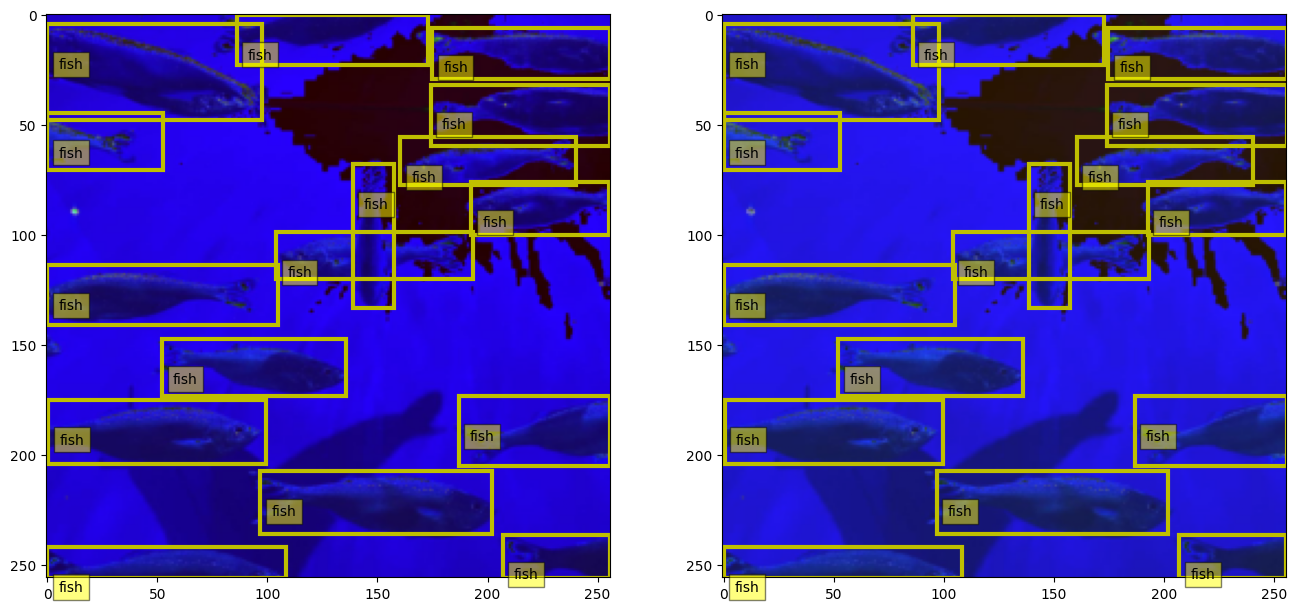

In [62]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0], classes=gt_class_1)
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1], classes=gt_class_2)

In [12]:
import numpy as np
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches

import os

import torch
import torchvision
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [13]:
model = torchvision.models.resnet101(pretrained=True)

C:\Users\Entezar\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Entezar\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [24]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [25]:
# run the image through the backbone
out = backbone(img_data_all)

In [26]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [27]:
out_c, out_h, out_w

(2048, 8, 8)

In [28]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

In [29]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

In [127]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor 
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

In [128]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [129]:
img_width = 256
img_height = 256

In [130]:
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h
height_scale_factor, width_scale_factor

(32, 32)

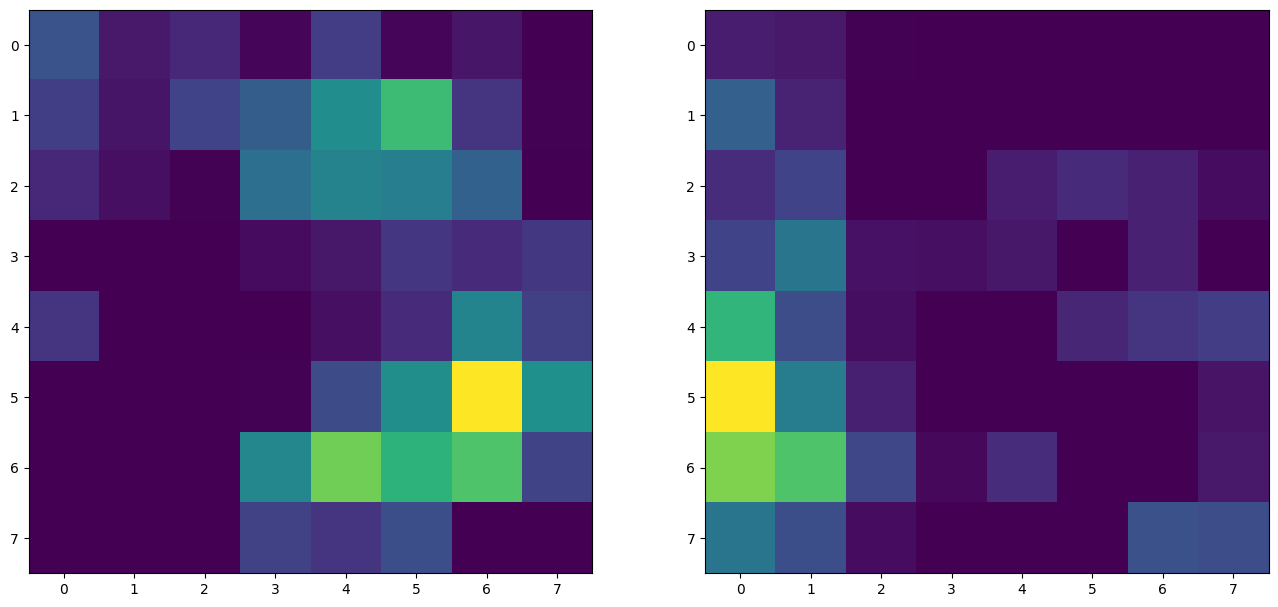

In [131]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data =[filters[0].detach().numpy() for filters in out[:2]]

fig, axes = display_img(filters_data, fig, axes)

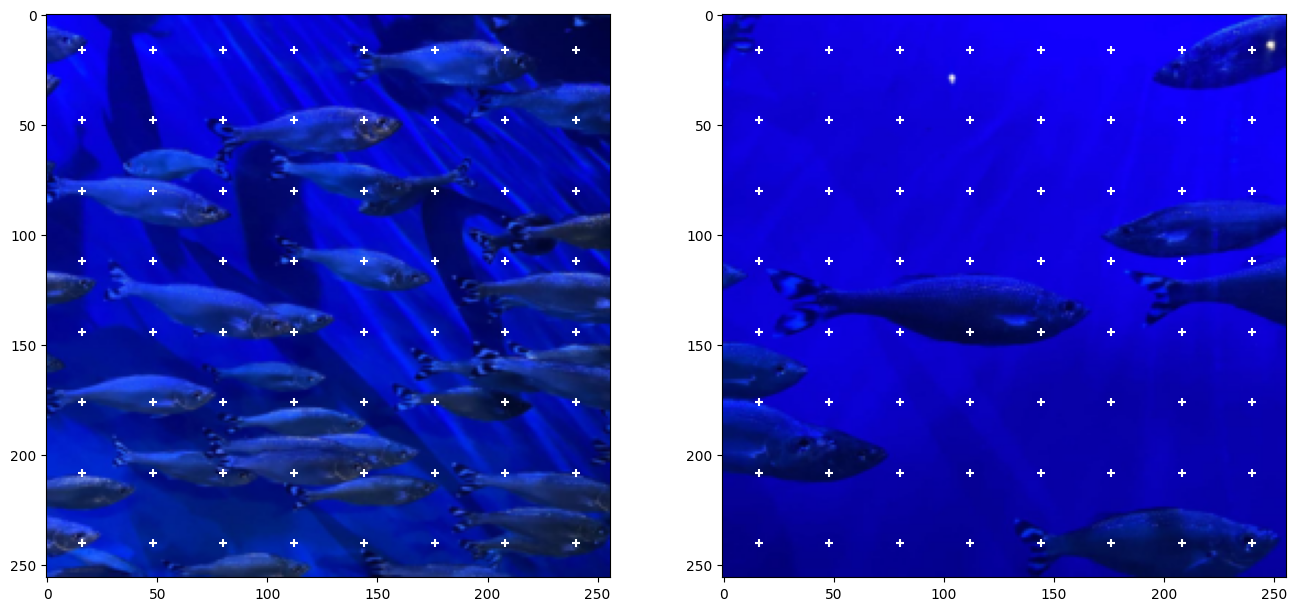

In [132]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
 
fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

In [133]:
anc_scales = [2, 4, 6]
anc_ratios = [0.5, 1, 1.5]
n_anc_boxes = len(anc_scales) * len(anc_ratios) # number of anchor boxes for each anchor point

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, (out_h, out_w))

In [134]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_all.size(dim=0), 1, 1, 1, 1)

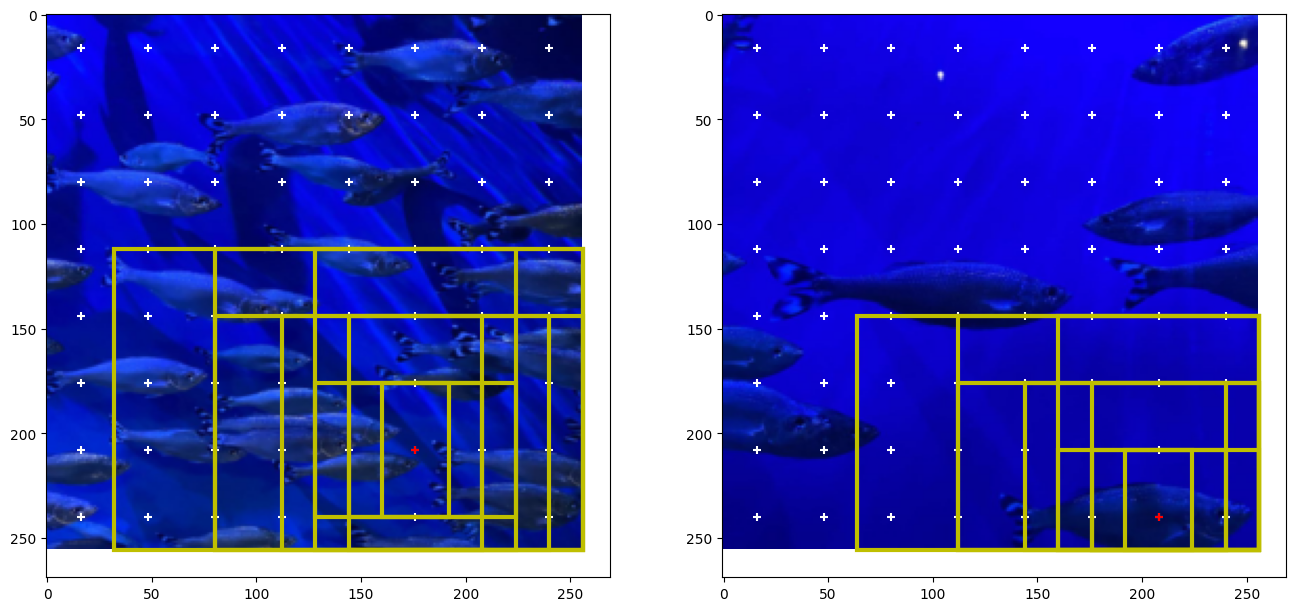

In [136]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
sp_1 = [5, 6]
sp_2 = [6, 7]
bboxes_1 = anc_boxes_proj[0][sp_1[0], sp_1[1]]
bboxes_2 = anc_boxes_proj[1][sp_2[0], sp_2[1]]

fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0], (anc_pts_x_proj[sp_1[0]], anc_pts_y_proj[sp_1[1]]))
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1], (anc_pts_x_proj[sp_2[0]], anc_pts_y_proj[sp_2[1]]))
fig, _ = display_bbox(bboxes_1, fig, axes[0])
fig, _ = display_bbox(bboxes_2, fig, axes[1])

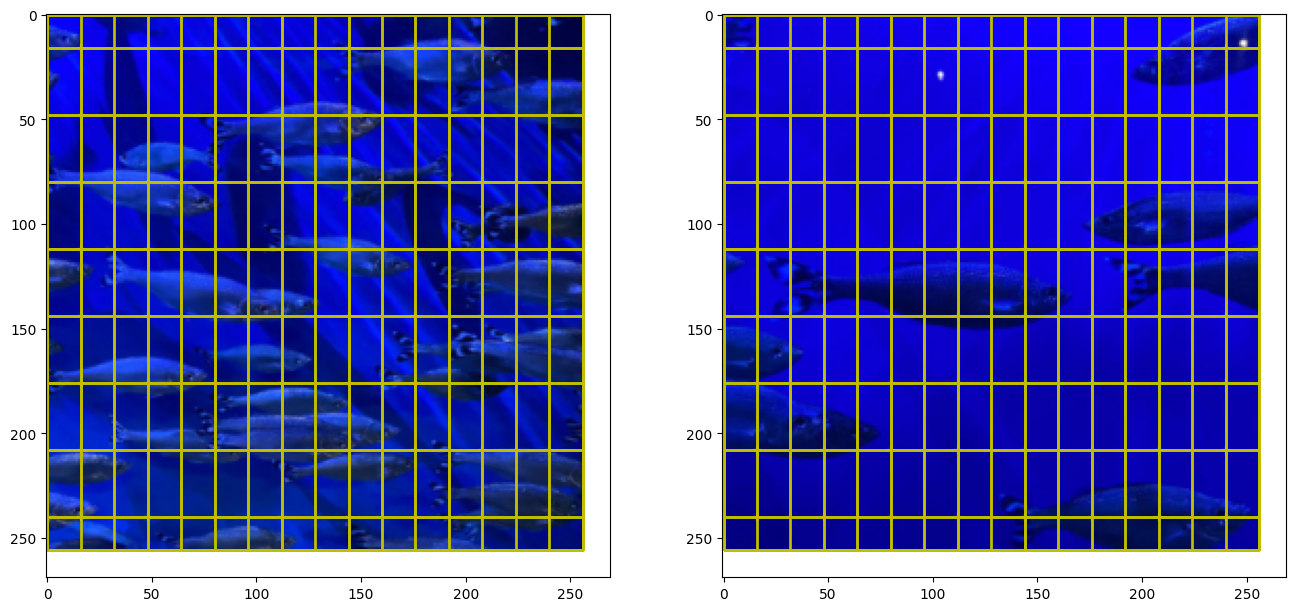

In [137]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)

# plot feature grid
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[0])
fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[1])

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        fig, _ = display_bbox(bboxes, fig, axes[0], line_width=1)
        fig, _ = display_bbox(bboxes, fig, axes[1], line_width=1)

# project ground truth boxes

In [138]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_all, width_scale_factor, height_scale_factor, mode='p2a')

In [140]:
positive_anc_ind, negative_anc_ind, GT_conf_scores, \
GT_offsets, GT_class_pos, positive_anc_coords, \
negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_all, pos_thresh, neg_thresh)

In [141]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_anc_coords, width_scale_factor, height_scale_factor, mode='a2p')

# grab +ve and -ve anchors for each image separately

anc_idx_1 = torch.where(positive_anc_ind_sep == 0)[0]
anc_idx_2 = torch.where(positive_anc_ind_sep == 1)[0]

pos_anc_1 = pos_anc_proj[anc_idx_1]
pos_anc_2 = pos_anc_proj[anc_idx_2]

neg_anc_1 = neg_anc_proj[anc_idx_1]
neg_anc_2 = neg_anc_proj[anc_idx_2]

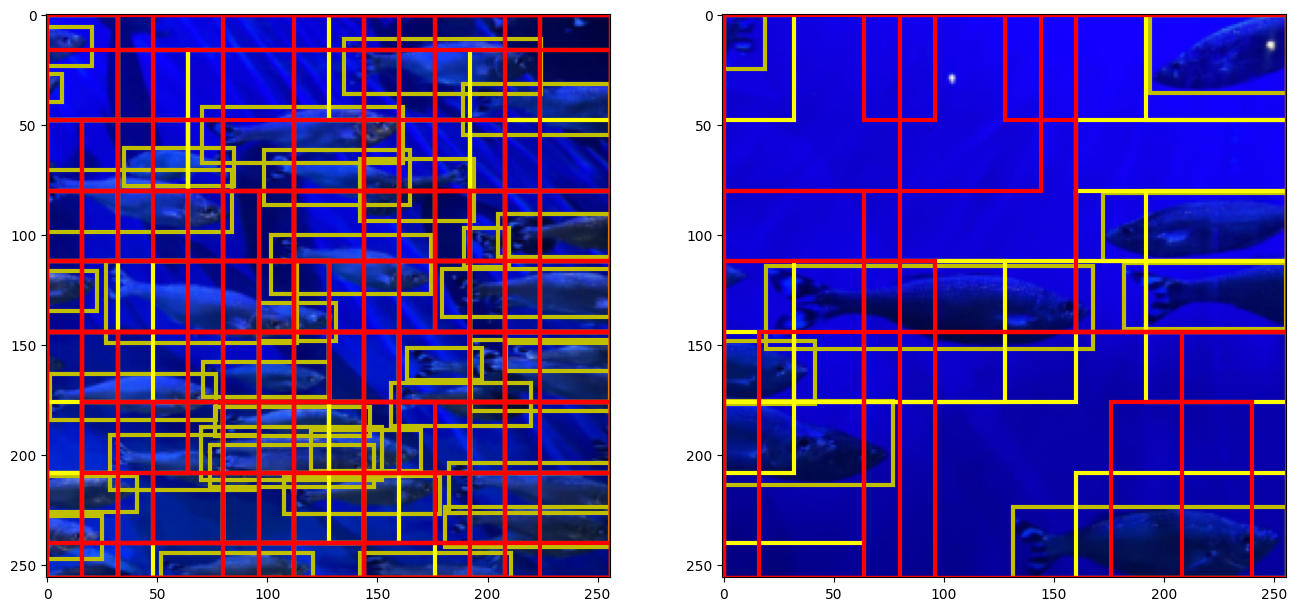

In [142]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16,16))

fig, axes = display_img(img_data_all, fig, axes)

# plot groundtruth bboxes
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

# plot positive anchor boxes
fig, _ = display_bbox(pos_anc_1, fig, axes[0], color='yellow')
fig, _ = display_bbox(pos_anc_2, fig, axes[1], color='yellow')

# plot negative anchor boxes
fig, _ = display_bbox(neg_anc_1, fig, axes[0], color='r')
fig, _ = display_bbox(neg_anc_2, fig, axes[1], color='r')

In [55]:
img_height =256
img_width = 256
img_size = (img_height, img_width)

out_size = (out_h, out_w)
n_classes = len(name2idx) - 1 # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [56]:
detector.eval()
total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

In [34]:
conf_scores_final

[tensor([0.6222, 0.6100, 0.6004, 0.5893, 0.5870, 0.5853, 0.5830, 0.5828, 0.5822,
         0.5816, 0.5816, 0.5815, 0.5806, 0.5779, 0.5763, 0.5749, 0.5729, 0.5726,
         0.5671, 0.5669, 0.5667, 0.5655, 0.5654, 0.5642, 0.5640, 0.5616, 0.5616,
         0.5614, 0.5610, 0.5606, 0.5603, 0.5588, 0.5569, 0.5563, 0.5556, 0.5555,
         0.5551, 0.5546, 0.5542, 0.5541, 0.5541, 0.5538, 0.5537, 0.5535, 0.5531,
         0.5508, 0.5507, 0.5505, 0.5500, 0.5499, 0.5494, 0.5489, 0.5488, 0.5486,
         0.5484, 0.5482, 0.5479, 0.5474, 0.5471, 0.5471, 0.5465, 0.5464, 0.5462,
         0.5460, 0.5457, 0.5444, 0.5443, 0.5442, 0.5441, 0.5440, 0.5434, 0.5432,
         0.5429, 0.5425, 0.5423, 0.5420, 0.5419, 0.5418, 0.5418, 0.5410, 0.5409,
         0.5408, 0.5405, 0.5402, 0.5397, 0.5397, 0.5387, 0.5381, 0.5378, 0.5377,
         0.5376, 0.5376, 0.5366, 0.5362, 0.5356, 0.5355, 0.5352, 0.5350, 0.5348,
         0.5346, 0.5345, 0.5344, 0.5343, 0.5342, 0.5337, 0.5337, 0.5334, 0.5334,
         0.5331, 0.5328, 0.5

In [35]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [49]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss = 0.0
    total = 0

    for img_batch, gt_bboxes_batch, gt_classes_batch in train_loader:
        img_batch, gt_bboxes_batch, gt_classes_batch = img_batch, gt_bboxes_batch, gt_classes_batch.to

        optimizer.zero_grad()
        loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    return train_loss / len(train_loader.dataset)

def validate(model, val_loader):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for img_batch, gt_bboxes_batch, gt_classes_batch in val_loader:
            img_batch, gt_bboxes_batch, gt_classes_batch = img_batch, gt_bboxes_batch, gt_classes_batch

            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            val_loss += loss.item()


    return val_loss / len(val_loader.dataset)




In [53]:
def train_loop(model, configs):
    #init
    train_losses = []
    val_losses = []

    optimizer, scheduler= configs['optimizer'], configs['scheduler']
    best_loss = np.inf
    best_model = None

    for epoch in range(configs['epochs']):

        train_loss  = train(model, configs['train_loader'], optimizer)
        val_loss  = validate(model, configs['val_loader'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{configs['epochs']}] - "
                f"Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Learning_rate: {optimizer.state_dict()['param_groups'][0]['lr']}")

        if val_loss < best_loss:
            print('saving the best model on validation data')
            best_loss = val_loss
            best_model = model


    history = {'train_loss' : train_losses ,'val_lass' : val_losses}

    return best_model , history

In [66]:
# You may need to redefine your own hyperparameters here to reach the best results
learning_rate = 1e-3
detector = detector
optimizer = optim.Adam(detector.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

configs = {'train_loader':dataloader,
           'val_loader':val_dataloader,
           'optimizer':optimizer, 'scheduler':scheduler, 'epochs':20}


best_model , history = train_loop(detector, configs)


AttributeError: 'builtin_function_or_method' object has no attribute 'view'